In [1]:
import os
import glob
import dqva
import random
import pickle
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from qiskit import *
from qiskit.quantum_info import Statevector

from utils.graph_funcs import *
from utils.helper_funcs import *

from ansatz import qaoa, dqv_ansatz, qls_ansatz, dqv_cut_ansatz

In [2]:
test_graphs = glob.glob('benchmark_graphs/N6_p20_graphs/*')
test_graphs = sorted(test_graphs, key=lambda g: int(g.split('/')[-1].strip('G.txt')))
print(len(test_graphs))

50


benchmark_graphs/N6_p20_graphs/G1.txt
Optimal: ('011100', 3)


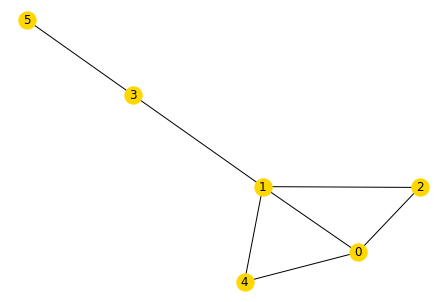

In [3]:
graph = test_graphs[0]
print(graph)
G = graph_from_file(graph)
print('Optimal:', brute_force_search(G))
nx.draw_spring(G, with_labels=True, node_color='gold')

# Test ansatz generation
## Quantum Alternating Operator Ansatz (QAOA)

In [10]:
nq = len(G.nodes())
P = 2
params = list(range(1, 2*P + 1))
mixer_order = list(range(nq))
#random.shuffle(mixer_order)
circ = qaoa.gen_qaoa(G, P, params=params, init_state='0'*nq, barriers=2,
                     decompose_toffoli=1, mixer_order=mixer_order, verbose=1)
circ.draw(fold=-1)

betas: [1, 3]
gammas: [2, 4]
Mixer order: [0, 1, 2, 3, 4, 5]
qubit: 0 num_qubits = 7 neighbors: [1, 2, 4]
qubit: 1 num_qubits = 7 neighbors: [0, 2, 3, 4]
qubit: 2 num_qubits = 7 neighbors: [0, 1]
qubit: 3 num_qubits = 7 neighbors: [1, 5]
qubit: 4 num_qubits = 7 neighbors: [0, 1]
qubit: 5 num_qubits = 7 neighbors: [3]
Mixer order: [0, 1, 2, 3, 4, 5]
qubit: 0 num_qubits = 7 neighbors: [1, 2, 4]
qubit: 1 num_qubits = 7 neighbors: [0, 2, 3, 4]
qubit: 2 num_qubits = 7 neighbors: [0, 1]
qubit: 3 num_qubits = 7 neighbors: [1, 5]
qubit: 4 num_qubits = 7 neighbors: [0, 1]
qubit: 5 num_qubits = 7 neighbors: [3]


░                ┌───────┐                ░ ┌───┐     ┌───┐  ┌───┐            ┌───┐ ░ ┌───┐       ┌───┐  ┌───┐     ┌───┐ ░                                         ░ ┌───┐       ┌───┐  ┌───┐     ┌───┐ ░                                    ░  ░ ┌───────┐ ░                ┌───────┐                ░ ┌───┐     ┌───┐  ┌───┐            ┌───┐ ░ ┌───┐       ┌───┐  ┌───┐     ┌───┐ ░                                         ░ ┌───┐       ┌───┐  ┌───┐     ┌───┐ ░                                    ░  ░ ┌───────┐ ░ 
  q_0: ─░────────────────┤ RX(2) ├────────────────░─┤ X ├──■──┤ X ├──┤ X ├─────────■──┤ X ├─░─┤ X ├──■────┤ X ├──┤ X ├──■──┤ X ├─░─────────────────────────────────────────░─┤ X ├──■────┤ X ├──┤ X ├──■──┤ X ├─░────────────────────────────────────░──░─┤ RZ(4) ├─░────────────────┤ RX(6) ├────────────────░─┤ X ├──■──┤ X ├──┤ X ├─────────■──┤ X ├─░─┤ X ├──■────┤ X ├──┤ X ├──■──┤ X ├─░─────────────────────────────────────────░─┤ X ├──■────┤ X ├──┤ X ├──■──┤ X ├─░────────────────────────────────────░──░─┤ RZ(8) ├─░─
        ░ ┌───┐     ┌───┐└───┬───┘┌───┐     ┌───┐ ░ └───┘  │  └───┘┌─┴───┴─┐       │  └───┘ ░ ├───┤  │    ├───┤  ├───┤  │  ├───┤ ░ ┌───┐     ┌───┐  ┌───┐            ┌───┐ ░ ├───┤  │    ├───┤  ├───┤  │  ├───┤ ░                                    ░  ░ ├───────┤ ░ ┌───┐     ┌───┐└───┬───┘┌───┐     ┌───┐ ░ └───┘  │  └───┘┌─┴───┴─┐       │  └───┘ ░ ├───┤  │    ├───┤  ├───┤  │  ├───┤ ░ ┌───┐     ┌───┐  ┌───┐            ┌───┐ ░ ├───┤  │    ├───┤  ├───┤  │  ├───┤ ░                                    ░  ░ ├───────┤ ░ 
  q_1: ─░─┤ X ├──■──┤ X ├────┼────┤ X ├──■──┤ X ├─░────────┼───────┤ RX(2) ├───────┼────────░─┤ X ├──■────┤ X ├──┤ X ├──■──┤ X ├─░─┤ X ├──■──┤ X ├──┤ X ├─────────■──┤ X ├─░─┤ X ├──■────┤ X ├──┤ X ├──■──┤ X ├─░────────────────────────────────────░──░─┤ RZ(4) ├─░─┤ X ├──■──┤ X ├────┼────┤ X ├──■──┤ X ├─░────────┼───────┤ RX(6) ├───────┼────────░─┤ X ├──■────┤ X ├──┤ X ├──■──┤ X ├─░─┤ X ├──■──┤ X ├──┤ X ├─────────■──┤ X ├─░─┤ X ├──■────┤ X ├──┤ X ├──■──┤ X ├─░────────────────────────────────────░──░─┤ RZ(8) ├─░─
        ░ ├───┤  │  ├───┤    │    ├───┤  │  ├───┤ ░ ┌───┐  │  ┌───┐└───┬───┘┌───┐  │  ┌───┐ ░ └───┘  │  ┌─┴───┴─┐└───┘  │  └───┘ ░ └───┘  │  └───┘  └───┘         │  └───┘ ░ └───┘  │    └───┘  └───┘  │  └───┘ ░                                    ░  ░ ├───────┤ ░ ├───┤  │  ├───┤    │    ├───┤  │  ├───┤ ░ ┌───┐  │  ┌───┐└───┬───┘┌───┐  │  ┌───┐ ░ └───┘  │  ┌─┴───┴─┐└───┘  │  └───┘ ░ └───┘  │  └───┘  └───┘         │  └───┘ ░ └───┘  │    └───┘  └───┘  │  └───┘ ░                                    ░  ░ ├───────┤ ░ 
  q_2: ─░─┤ X ├──■──┤ X ├────┼────┤ X ├──■──┤ X ├─░─┤ X ├──■──┤ X ├────┼────┤ X ├──■──┤ X ├─░────────┼──┤ RX(2) ├───────┼────────░────────┼───────────────────────┼────────░────────┼──────────────────┼────────░────────────────────────────────────░──░─┤ RZ(4) ├─░─┤ X ├──■──┤ X ├────┼────┤ X ├──■──┤ X ├─░─┤ X ├──■──┤ X ├────┼────┤ X ├──■──┤ X ├─░────────┼──┤ RX(6) ├───────┼────────░────────┼───────────────────────┼────────░────────┼──────────────────┼────────░────────────────────────────────────░──░─┤ RZ(8) ├─░─
        ░ └───┘  │  └───┘    │    └───┘  │  └───┘ ░ ├───┤  │  ├───┤    │    ├───┤  │  ├───┤ ░        │  └───┬───┘       │        ░        │       ┌───────┐       │        ░        │                  │        ░ ┌───┐       ┌───┐  ┌───┐     ┌───┐ ░  ░ ├───────┤ ░ └───┘  │  └───┘    │    └───┘  │  └───┘ ░ ├───┤  │  ├───┤    │    ├───┤  │  ├───┤ ░        │  └───┬───┘       │        ░        │       ┌───────┐       │        ░        │                  │        ░ ┌───┐       ┌───┐  ┌───┐     ┌───┐ ░  ░ ├───────┤ ░ 
  q_3: ─░────────┼───────────┼───────────┼────────░─┤ X ├──■──┤ X ├────┼────┤ X ├──■──┤ X ├─░────────┼──────┼───────────┼────────░────────┼───────┤ RX(2) ├───────┼────────░────────┼──────────────────┼────────░─┤ X ├──■────┤ X ├──┤ X ├──■──┤ X ├─░──░─┤ RZ(4) ├─░────────┼───────────┼───────────┼────────░─┤ X ├──■──┤ X ├────┼────┤ X ├──■──┤ X ├─░────────┼──────┼───────────┼────────░────────┼───────┤ RX(

## Dynamic Quantum Variational Ansatz (DQVA)

In [4]:
nq = len(G.nodes())
P = 2
mixer_order = list(range(nq))
random.shuffle(mixer_order)
#init_state = '0'*nq
init_state = '000001'
params = list(range(1, P*((nq-hamming_weight(init_state)) + 1) + 1))
circ = dqv_ansatz.gen_dqva(G, P=P, params=params, init_state=init_state, barriers=2,
                               decompose_toffoli=0, mixer_order=mixer_order, verbose=1)
circ.draw(fold=-1)

alpha_0: [1, 2, 3, 4, 5]
gamma_0: 6
alpha_1: [7, 8, 9, 10, 11]
gamma_1: 12
Mixer order: [3, 0, 4, 2, 5, 1]
init_state: 000001, alpha: [1, 2, 3, 4, 5], pad_alpha: [None, 5, 3, 1, 2, 4]
qubit: 3 num_qubits = 7 neighbors: [1, 5]
qubit: 4 num_qubits = 7 neighbors: [0, 1]
qubit: 2 num_qubits = 7 neighbors: [0, 1]
qubit: 5 num_qubits = 7 neighbors: [3]
qubit: 1 num_qubits = 7 neighbors: [0, 2, 3, 4]
Mixer order: [3, 0, 4, 2, 5, 1]
init_state: 000001, alpha: [7, 8, 9, 10, 11], pad_alpha: [None, 11, 9, 7, 8, 10]
qubit: 3 num_qubits = 7 neighbors: [1, 5]
qubit: 4 num_qubits = 7 neighbors: [0, 1]
qubit: 2 num_qubits = 7 neighbors: [0, 1]
qubit: 5 num_qubits = 7 neighbors: [3]
qubit: 1 num_qubits = 7 neighbors: [0, 2, 3, 4]


┌───┐ ░                     ░                     ░                     ░                     ░                      ░  ░ ┌────────┐ ░                      ░                      ░                      ░                      ░                      ░  ░ ┌────────┐ ░ 
  q_0: ┤ X ├─░─────────────────────░───o─────────────o───░───o─────────────o───░─────────────────────░───o──────────────o───░──░─┤ RZ(12) ├─░──────────────────────░───o──────────────o───░───o──────────────o───░──────────────────────░───o──────────────o───░──░─┤ RZ(24) ├─░─
       └───┘ ░                     ░   │             │   ░   │             │   ░                     ░   │  ┌────────┐  │   ░  ░ ├────────┤ ░                      ░   │              │   ░   │              │   ░                      ░   │  ┌────────┐  │   ░  ░ ├────────┤ ░ 
  q_1: ──────░───o─────────────o───░───o─────────────o───░───o─────────────o───░─────────────────────░───┼──┤ RX(10) ├──┼───░──░─┤ RZ(12) ├─░───o──────────────o───░───o──────────────o───░───o──────────────o───░──────────────────────░───┼──┤ RX(22) ├──┼───░──░─┤ RZ(24) ├─░─
             ░   │             │   ░   │             │   ░   │  ┌───────┐  │   ░                     ░   │  └───┬────┘  │   ░  ░ ├────────┤ ░   │              │   ░   │              │   ░   │  ┌────────┐  │   ░                      ░   │  └───┬────┘  │   ░  ░ ├────────┤ ░ 
  q_2: ──────░───┼─────────────┼───░───┼─────────────┼───░───┼──┤ RX(6) ├──┼───░─────────────────────░───o──────┼───────o───░──░─┤ RZ(12) ├─░───┼──────────────┼───░───┼──────────────┼───░───┼──┤ RX(18) ├──┼───░──────────────────────░───o──────┼───────o───░──░─┤ RZ(24) ├─░─
             ░   │  ┌───────┐  │   ░   │             │   ░   │  └───┬───┘  │   ░                     ░   │      │       │   ░  ░ ├────────┤ ░   │  ┌────────┐  │   ░   │              │   ░   │  └───┬────┘  │   ░                      ░   │      │       │   ░  ░ ├────────┤ ░ 
  q_3: ──────░───┼──┤ RX(2) ├──┼───░───┼─────────────┼───░───┼──────┼──────┼───░───o─────────────o───░───o──────┼───────o───░──░─┤ RZ(12) ├─░───┼──┤ RX(14) ├──┼───░───┼──────────────┼───░───┼──────┼───────┼───░───o──────────────o───░───o──────┼───────o───░──░─┤ RZ(24) ├─░─
             ░   │  └───┬───┘  │   ░   │  ┌───────┐  │   ░   │      │      │   ░   │             │   ░   │      │       │   ░  ░ ├────────┤ ░   │  └───┬────┘  │   ░   │  ┌────────┐  │   ░   │      │       │   ░   │              │   ░   │      │       │   ░  ░ ├────────┤ ░ 
  q_4: ──────░───┼──────┼──────┼───░───┼──┤ RX(4) ├──┼───░───┼──────┼──────┼───░───┼─────────────┼───░───o──────┼───────o───░──░─┤ RZ(12) ├─░───┼──────┼───────┼───░───┼──┤ RX(16) ├──┼───░───┼──────┼───────┼───░───┼──────────────┼───░───o──────┼───────o───░──░─┤ RZ(24) ├─░─
             ░   │      │      │   ░   │  └───┬───┘  │   ░   │      │      │   ░   │  ┌───────┐  │   ░   │      │       │   ░  ░ ├────────┤ ░   │      │       │   ░   │  └───┬────┘  │   ░   │      │       │   ░   │  ┌────────┐  │   ░   │      │       │   ░  ░ ├────────┤ ░ 
  q_5: ──────░───o──────┼──────o───░───┼──────┼──────┼───░───┼──────┼──────┼───░───┼──┤ RX(8) ├──┼───░───┼──────┼───────┼───░──░─┤ RZ(12) ├─░───o──────┼───────o───░───┼──────┼───────┼───░───┼──────┼───────┼───░───┼──┤ RX(20) ├──┼───░───┼──────┼───────┼───░──░─┤ RZ(24) ├─░─
             ░ ┌─┴─┐    │    ┌─┴─┐ ░ ┌─┴─┐    │    ┌─┴─┐ ░ ┌─┴─┐    │    ┌─┴─┐ ░ ┌─┴─┐└───┬───┘┌─┴─┐ ░ ┌─┴─┐    │     ┌─┴─┐ ░  ░ └────────┘ ░ ┌─┴─┐    │     ┌─┴─┐ ░ ┌─┴─┐    │     ┌─┴─┐ ░ ┌─┴─┐    │     ┌─┴─┐ ░ ┌─┴─┐└───┬────┘┌─┴─┐ ░ ┌─┴─┐    │     ┌─┴─┐ ░  ░ └────────┘ ░ 
anc_0: ──────░─┤ X ├────■────┤ X ├─░─┤ X ├────■────┤ X ├─░─┤ X ├────■────┤ X ├─░─┤ X ├────■────┤ X ├─░─┤ X ├────■─────┤ X ├─░──░────────────░─┤ X ├────■─────┤ X ├─░─┤ X ├────■─────┤ X ├─░─┤ X ├────■─────┤ X ├─░─┤ X ├────■─────┤ X ├─░─┤ X ├────■─────┤ X ├─░──░────────────░─
             ░ └───┘         └───┘ ░ └───┘         └───┘ ░ └───┘         └───┘ ░ └───┘         └───┘ ░ └───┘          └───┘ ░  ░            ░ └───┘          └───┘ ░ └───┘ 

## Quantum Local Search Ansatz (QLSA)

In [20]:
nq = len(G.nodes())
P = 1
mixer_order = list(range(nq))
random.shuffle(mixer_order)

init_state = '010000'
num_nonzero = nq - hamming_weight(init_state)
print('lim1:', P * (nq + 1))
print('lim2:', (P+1) * (num_nonzero + 1))
param_lim = 3
if param_lim is None:
    num_params = min(P * (nq + 1), (P+1) * (num_nonzero + 1))
else:
    num_params = param_lim
params = list(range(1, num_params + 1))
print(params)

circ = qls_ansatz.gen_qlsa(G, P=P, params=params, init_state=init_state, barriers=1,
                           decompose_toffoli=0, mixer_order=mixer_order, verbose=1, param_lim=param_lim)
circ.draw(fold=-1)

lim1: 7
lim2: 12
[1, 2, 3]
alpha_0: [2, 3]
gamma_0: 1
init_state: 010000, alpha: [2, 3], pad_alpha: [None, None, None, 2, None, 3]
Mixer order: [4, 3, 5, 0, 1, 2]
qubit: 3 num_qubits = 7 neighbors: [1, 5]
qubit: 5 num_qubits = 7 neighbors: [3]


░                                        ░ ┌───────┐ ░ 
  q_0: ──────░────────────────────────────────────────░─┤ RZ(2) ├─░─
             ░                                        ░ ├───────┤ ░ 
  q_1: ──────░───o─────────────o──────────────────────░─┤ RZ(2) ├─░─
             ░   │             │                      ░ ├───────┤ ░ 
  q_2: ──────░───┼─────────────┼──────────────────────░─┤ RZ(2) ├─░─
             ░   │  ┌───────┐  │                      ░ ├───────┤ ░ 
  q_3: ──────░───┼──┤ RX(4) ├──┼────o─────────────o───░─┤ RZ(2) ├─░─
       ┌───┐ ░   │  └───┬───┘  │    │             │   ░ ├───────┤ ░ 
  q_4: ┤ X ├─░───┼──────┼──────┼────┼─────────────┼───░─┤ RZ(2) ├─░─
       └───┘ ░   │      │      │    │  ┌───────┐  │   ░ ├───────┤ ░ 
  q_5: ──────░───o──────┼──────o────┼──┤ RX(6) ├──┼───░─┤ RZ(2) ├─░─
             ░ ┌─┴─┐    │    ┌─┴─┐┌─┴─┐└───┬───┘┌─┴─┐ ░ └───────┘ ░ 
anc_0: ──────░─┤ X ├────■────┤ X ├┤ X ├────■────┤ X ├─░───────────░─
             ░ └───┘         └───┘└───┘         └───┘ ░           ░

In [38]:
nq = len(G.nodes())
P = 1
mixer_order = list(range(nq))
random.shuffle(mixer_order)

init_state = '101111'
num_nonzero = nq - hamming_weight(init_state)
print('lim1:', P * (nq + 1))
print('lim2:', (P+1) * (num_nonzero + 1))
num_params = min(P * (nq + 1), (P+1) * (num_nonzero + 1))
params = list(range(1, num_params + 1))
print(params)

circ = dqv_cut_ansatz.gen_cut_dqva(G, P=P, params=params, init_state=init_state, barriers=1,
                           decompose_toffoli=0, mixer_order=mixer_order, verbose=1)
circ.draw(fold=-1)

lim1: 9
lim2: 8
[1, 2, 3, 4, 5, 6, 7, 8]


TypeError: gen_cut_dqva() missing 1 required positional argument: 'partition'

# Test each algorithm
## QAOA

In [21]:
nq = len(G.nodes())
P = 2
mixer_order = list(range(nq))
random.shuffle(mixer_order)
init_state = '0'*nq
sim = 'qasm'
shots = 10000
dqva.solve_mis_qaoa(init_state, G, P=P, m=3, mixer_order=mixer_order, sim=sim, shots=shots,
                    verbose=1)

Start round 1.1, Initial state = 000000
	Num params = 4
	Current Mixer Order: [1, 4, 2, 5, 0, 3]
	Optimal cost: -2.0035999999999996
	Found new independent set: 100010, Hamming weight = 2
Start round 1.2, Initial state = 100010
	Num params = 4
	Current Mixer Order: [1, 4, 2, 5, 0, 3]
	Optimal cost: -2.9995
	Found new independent set: 011100, Hamming weight = 3
Start round 1.3, Initial state = 011100
	Num params = 4
	Current Mixer Order: [1, 4, 2, 5, 0, 3]
	Optimal cost: -3.0
	None of the measured bitstrings had higher Hamming weight than: 011100
Start round 2.1, Initial state = 011100
	Num params = 4
	Current Mixer Order: [0, 2, 5, 3, 1, 4]
	Optimal cost: -3.0
	None of the measured bitstrings had higher Hamming weight than: 011100
Start round 3.1, Initial state = 011100
	Num params = 4
	Current Mixer Order: [2, 5, 3, 1, 0, 4]
	Optimal cost: -3.0
	None of the measured bitstrings had higher Hamming weight than: 011100
	RETURNING, best hamming weight: 3


('011100',
 array([-1.55713761, -0.07664812, -0.01073848, -0.08414296]),
 '100010',
 [1, 4, 2, 5, 0, 3],
 [[{'mixer_round': 1,
    'inner_round': 1,
    'cost': -2.0035999999999996,
    'init_state': '000000',
    'mixer_order': [1, 4, 2, 5, 0, 3],
    'num_params': 4},
   {'mixer_round': 1,
    'inner_round': 2,
    'cost': -2.9995,
    'init_state': '100010',
    'mixer_order': [1, 4, 2, 5, 0, 3],
    'num_params': 4},
   {'mixer_round': 1,
    'inner_round': 3,
    'cost': -3.0,
    'init_state': '011100',
    'mixer_order': [1, 4, 2, 5, 0, 3],
    'num_params': 4}],
  [{'mixer_round': 2,
    'inner_round': 1,
    'cost': -3.0,
    'init_state': '011100',
    'mixer_order': [0, 2, 5, 3, 1, 4],
    'num_params': 4}],
  [{'mixer_round': 3,
    'inner_round': 1,
    'cost': -3.0,
    'init_state': '011100',
    'mixer_order': [2, 5, 3, 1, 0, 4],
    'num_params': 4}]])

## DQVA

In [5]:
nq = len(G.nodes())
P = 1
mixer_order = list(range(nq))
random.shuffle(mixer_order)
init_state = '0'*nq
sim = 'statevector'
shots = 10000
dqva.solve_mis_dqva(init_state, G, P=P, m=2, mixer_order=mixer_order, sim=sim, shots=shots,
                    verbose=1)

Start round 1.1, Initial state = 000000
	Num params = 7
	Current Mixer Order: [0, 1, 2, 5, 3, 4]
	Optimal cost: -2.9999200000000004
	Found new independent set: 110100, Hamming weight = 3
Start round 1.2, Initial state = 110100
	Num params = 4
	Current Mixer Order: [0, 1, 2, 5, 3, 4]
	Optimal cost: -3.0
	None of the measured bitstrings had higher Hamming weight than: 110100
Start round 2.1, Initial state = 110100
	Num params = 4
	Current Mixer Order: [3, 2, 5, 1, 4, 0]
	Optimal cost: -3.0
	None of the measured bitstrings had higher Hamming weight than: 110100
	RETURNING, best hamming weight: 3


('110100',
 array([3.14530247e+00, 2.85010658e-04, 1.57264016e+00, 1.14285113e+00,
        1.59036118e+00, 1.56981598e+00, 7.00778396e-01]),
 '000000',
 [0, 1, 2, 5, 3, 4],
 [[{'mixer_round': 1,
    'inner_round': 1,
    'cost': -2.9999200000000004,
    'init_state': '000000',
    'mixer_order': [0, 1, 2, 5, 3, 4],
    'num_params': 7},
   {'mixer_round': 1,
    'inner_round': 2,
    'cost': -3.0,
    'init_state': '110100',
    'mixer_order': [0, 1, 2, 5, 3, 4],
    'num_params': 4}],
  [{'mixer_round': 2,
    'inner_round': 1,
    'cost': -3.0,
    'init_state': '110100',
    'mixer_order': [3, 2, 5, 1, 4, 0],
    'num_params': 4}]])

## QLS

In [23]:
nq = len(G.nodes())
P = 1
mixer_order = list(range(nq))
random.shuffle(mixer_order)
init_state = '0'*nq
sim = 'qasm'
shots = 10000
dqva.solve_mis_qls(init_state, G, P=P, m=4, mixer_order=None, sim=sim, shots=shots,
                    verbose=1, param_lim=3)

Start round 1.1, Initial state = 000000
	Num params = 3
	Current Mixer Order: [5, 2, 3, 4, 1, 0]
	Optimal cost: -2.0
	Found new independent set: 100100, Hamming weight = 2
Start round 1.2, Initial state = 100100
	Num params = 3
	Current Mixer Order: [5, 2, 3, 4, 1, 0]
	Optimal cost: -3.0
	Found new independent set: 110100, Hamming weight = 3
Start round 1.3, Initial state = 110100
	Num params = 3
	Current Mixer Order: [5, 2, 3, 4, 1, 0]
	Optimal cost: -3.0
	None of the measured bitstrings had higher Hamming weight than: 110100
Start round 2.1, Initial state = 110100
	Num params = 3
	Current Mixer Order: [5, 2, 0, 4, 3, 1]
	Optimal cost: -3.0
	None of the measured bitstrings had higher Hamming weight than: 110100
Start round 3.1, Initial state = 110100
	Num params = 3
	Current Mixer Order: [5, 2, 3, 4, 0, 1]
	Optimal cost: -3.0
	None of the measured bitstrings had higher Hamming weight than: 110100
Start round 4.1, Initial state = 110100
	Num params = 3
	Current Mixer Order: [5, 2, 0, 4

('110100',
 array([0.01204476, 0.05597119, 1.56716949]),
 '100100',
 [5, 2, 3, 4, 1, 0],
 [[{'mixer_round': 1,
    'inner_round': 1,
    'cost': -2.0,
    'init_state': '000000',
    'mixer_order': [5, 2, 3, 4, 1, 0],
    'num_params': 3},
   {'mixer_round': 1,
    'inner_round': 2,
    'cost': -3.0,
    'init_state': '100100',
    'mixer_order': [5, 2, 3, 4, 1, 0],
    'num_params': 3},
   {'mixer_round': 1,
    'inner_round': 3,
    'cost': -3.0,
    'init_state': '110100',
    'mixer_order': [5, 2, 3, 4, 1, 0],
    'num_params': 3}],
  [{'mixer_round': 2,
    'inner_round': 1,
    'cost': -3.0,
    'init_state': '110100',
    'mixer_order': [5, 2, 0, 4, 3, 1],
    'num_params': 3}],
  [{'mixer_round': 3,
    'inner_round': 1,
    'cost': -3.0,
    'init_state': '110100',
    'mixer_order': [5, 2, 3, 4, 0, 1],
    'num_params': 3}],
  [{'mixer_round': 4,
    'inner_round': 1,
    'cost': -3.0,
    'init_state': '110100',
    'mixer_order': [5, 2, 0, 4, 3, 1],
    'num_params': 3}]])

# Plot results

In [24]:
def get_data(alg, P, sim, d, lim=None):
    
    graph_sizes, mis_approxs, mis_list = [], [], []
    
    base_path = 'benchmark_results/{}_P{}_{}/'.format(alg, P, sim)
    if d < 10:
        graph_paths = 'N*_d{}_graphs/'.format(d)
    else:
        graph_paths = 'N*_p{}_graphs/'.format(d)
    
    graph_dirs = glob.glob(base_path + graph_paths)
    graph_dirs = sorted(graph_dirs, key=lambda fn: int(fn.split('/')[-2].split('_')[0].strip('N')))
    
    for gd in graph_dirs:
        print(gd)
        graph_size = int(gd.split('/')[-2].split('_')[0].strip('N'))
        all_graphs = glob.glob(gd+'*')
        temp_mis_approx = []
        for graph in all_graphs:
            #print('\t', graph)
            graphfn = 'benchmark_graphs/' + '/'.join(graph.split('/')[-2:]) + '.txt'
            G = graph_from_file(graphfn)
            opt = brute_force_search(G)[1]
            #print('\t Opt =', opt)
            if alg == 'qlsa' and d > 10:
                if lim is None:
                    raise Exception('Must specify lim parameter with alg=qlsa')
                reps = glob.glob(graph+'/*_lim{}_*'.format(lim))
            else:
                reps = glob.glob(graph+'/*')
            temp_reps = []
            for pklfile in reps:
                #print('\t\t', pklfile)
                with open(pklfile, 'rb') as pf:
                    res = pickle.load(pf)
                    #print('\t'*3, res['graph'])
                    #print('\t'*3, res['out'][0])
                    #temp_mis_approx.append(hamming_weight(res['out'][0]) / opt)
                    temp_reps.append(hamming_weight(res['out'][0]) / opt)
            # add the best of the 5 trials
            temp_mis_approx.append(max(temp_reps))
        
        # after collecting data for all graphs of this size,
        # store the average
        graph_sizes.append(graph_size)
        mis_approxs.append(np.mean(temp_mis_approx))
        mis_list.append(temp_mis_approx)
    
    return graph_sizes, mis_approxs, mis_list

# Load data in

In [25]:
d = 20
data = []
lists = []

In [23]:
qva_sizes, qva_mis, qva_mis_list = get_data('qva', 1, 'qasm', d)
data.append((qva_sizes, qva_mis, 'QVA, P=1'))
lists.append((qva_sizes, qva_mis_list, 'QVA, P=1'))

benchmark_results/qva_P1_qasm/N6_p20_graphs/
benchmark_results/qva_P1_qasm/N8_p20_graphs/
benchmark_results/qva_P1_qasm/N10_p20_graphs/
benchmark_results/qva_P1_qasm/N12_p20_graphs/
benchmark_results/qva_P1_qasm/N14_p20_graphs/
benchmark_results/qva_P1_qasm/N16_p20_graphs/


In [26]:
qaoa_sizes, qaoa_mis, qaoa_p1_mis_list = get_data('qaoa', 1, 'qasm', d)
data.append((qaoa_sizes, qaoa_mis, 'QAOA, P=1'))
lists.append((qaoa_sizes, qaoa_p1_mis_list, 'QAOA, P=1'))

benchmark_results/qaoa_P1_qasm/N6_p20_graphs/
benchmark_results/qaoa_P1_qasm/N8_p20_graphs/
benchmark_results/qaoa_P1_qasm/N10_p20_graphs/
benchmark_results/qaoa_P1_qasm/N12_p20_graphs/
benchmark_results/qaoa_P1_qasm/N14_p20_graphs/
benchmark_results/qaoa_P1_qasm/N16_p20_graphs/


In [27]:
qaoa_p2_sizes, qaoa_p2_mis, qaoa_p2_mis_list = get_data('qaoa', 2, 'qasm', d)
data.append((qaoa_p2_sizes, qaoa_p2_mis, 'QAOA, P=2'))
lists.append((qaoa_p2_sizes, qaoa_p2_mis_list, 'QAOA, P=2'))

benchmark_results/qaoa_P2_qasm/N6_p20_graphs/
benchmark_results/qaoa_P2_qasm/N8_p20_graphs/
benchmark_results/qaoa_P2_qasm/N10_p20_graphs/
benchmark_results/qaoa_P2_qasm/N12_p20_graphs/
benchmark_results/qaoa_P2_qasm/N14_p20_graphs/
benchmark_results/qaoa_P2_qasm/N16_p20_graphs/


In [28]:
qaoa_p3_sizes, qaoa_p3_mis, qaoa_p3_mis_list = get_data('qaoa', 3, 'qasm', d)
data.append((qaoa_p3_sizes, qaoa_p3_mis, 'QAOA, P=3'))
lists.append((qaoa_sizes, qaoa_p3_mis_list, 'QAOA, P=3'))

benchmark_results/qaoa_P3_qasm/N6_p20_graphs/
benchmark_results/qaoa_P3_qasm/N8_p20_graphs/
benchmark_results/qaoa_P3_qasm/N10_p20_graphs/
benchmark_results/qaoa_P3_qasm/N12_p20_graphs/
benchmark_results/qaoa_P3_qasm/N14_p20_graphs/
benchmark_results/qaoa_P3_qasm/N16_p20_graphs/


In [29]:
qlsa_sizes, qlsa_mis, qlsa_mis_list = get_data('qlsa', 1, 'qasm', d, lim=2)
data.append((qlsa_sizes, qlsa_mis, 'QLS, lim=2'))
lists.append((qlsa_sizes, qlsa_mis_list, 'QLS, lim=2'))

benchmark_results/qlsa_P1_qasm/N6_p20_graphs/
benchmark_results/qlsa_P1_qasm/N8_p20_graphs/
benchmark_results/qlsa_P1_qasm/N10_p20_graphs/
benchmark_results/qlsa_P1_qasm/N12_p20_graphs/
benchmark_results/qlsa_P1_qasm/N14_p20_graphs/
benchmark_results/qlsa_P1_qasm/N16_p20_graphs/


In [30]:
qlsa_sizes, qlsa_mis, qlsa_mis_list = get_data('qlsa', 1, 'qasm', d, lim=4)
data.append((qlsa_sizes, qlsa_mis, 'QLS, lim=4'))
lists.append((qlsa_sizes, qlsa_mis_list, 'QLS, lim=4'))

benchmark_results/qlsa_P1_qasm/N6_p20_graphs/
benchmark_results/qlsa_P1_qasm/N8_p20_graphs/
benchmark_results/qlsa_P1_qasm/N10_p20_graphs/
benchmark_results/qlsa_P1_qasm/N12_p20_graphs/
benchmark_results/qlsa_P1_qasm/N14_p20_graphs/


ValueError: max() arg is an empty sequence

In [32]:
qlsa_sizes, qlsa_mis, qlsa_mis_list = get_data('qlsa', 1, 'qasm', d, lim=6)
data.append((qlsa_sizes, qlsa_mis, 'QLS, lim=6'))
lists.append((qlsa_sizes, qlsa_mis_list, 'QLS, lim=6'))

benchmark_results/qlsa_P1_qasm/N6_p20_graphs/
benchmark_results/qlsa_P1_qasm/N8_p20_graphs/
benchmark_results/qlsa_P1_qasm/N10_p20_graphs/
benchmark_results/qlsa_P1_qasm/N12_p20_graphs/
benchmark_results/qlsa_P1_qasm/N14_p20_graphs/
benchmark_results/qlsa_P1_qasm/N16_p20_graphs/


# Compare algorithms

In [33]:
def plot_approximation_ratio(data, lists, d, savedir=None, show=True):
    
    if d > 10:
        titlestr = 'Random p={} Erdos-Renyi graphs'.format(d)
    else:
        titlestr = 'Random {}-regular graphs'.format(d)
    
    # Plot just the approximation ratio
    fig, ax = plt.subplots(dpi=150)
    for sizes, approxs, label in data:
        ax.plot(sizes, approxs, label=label)
    ax.set_ylabel('Approximation ratio')
    ax.set_xlabel('Number of nodes')
    ax.set_title(titlestr)
    ax.legend()
    
    if not savedir is None:
        if savedir[-1] != '/':
            savedir += '/'
        plt.savefig(savedir + 'ratio.png')
        
    if show:
        plt.show()
    plt.close()
    
    # Plot ratio with max and min values
    fig, ax = plt.subplots(dpi=150)
    offset = np.linspace(-0.2, 0.2, len(lists))

    for i, (sizes, mis_list, label) in enumerate(lists):
        sizes = np.array(sizes) + offset[i]
        vals = [np.mean(l) for l in mis_list]
        upper_err = [abs(np.max(l) - z) for l, z in zip(mis_list, vals)]
        lower_err = [abs(np.min(l) - z) for l, z in zip(mis_list, vals)]
        ax.errorbar(sizes, vals, yerr=[lower_err, upper_err], label=label, elinewidth=1, capsize=2)
    
    ax.set_ylabel('Approximation ratio')
    ax.set_xlabel('Number of nodes')
    ax.set_title(titlestr + ' (max, min)')
    ax.legend()
    
    if not savedir is None:
        if savedir[-1] != '/':
            savedir += '/'
        plt.savefig(savedir + 'ratio_maxmin.png')
        
    if show:
        plt.show()
    plt.close()

    # Plot ratio with Q1 and Q3 values
    fig, ax = plt.subplots(dpi=150)
    offset = np.linspace(-0.2, 0.2, len(lists))

    for i, (sizes, mis_list, label) in enumerate(lists):
        sizes = np.array(sizes) + offset[i]
        vals = [np.mean(l) for l in mis_list]
        upper_err = [abs(np.quantile(l, 0.75) - z) for l, z in zip(mis_list, vals)]
        lower_err = [abs(np.quantile(l, 0.25) - z) for l, z in zip(mis_list, vals)]
        ax.errorbar(sizes, vals, yerr=[lower_err, upper_err], label=label, elinewidth=1, capsize=2)

    ax.set_ylabel('Approximation ratio')
    ax.set_xlabel('Number of nodes')
    ax.set_title(titlestr + ' (Q1, Q3)')
    ax.legend()
    
    if not savedir is None:
        if savedir[-1] != '/':
            savedir += '/'
        plt.savefig(savedir + 'ratio_Q1Q3.png')
        
    if show:
        plt.show()
    plt.close()

In [36]:
# Save all data to figures
for d in [20, 30, 50]:
    data = []
    lists = []

    #qva_sizes, qva_mis, qva_mis_list = get_data('qva', 1, 'qasm', d)
    #data.append((qva_sizes, qva_mis, 'QVA, P=1'))
    #lists.append((qva_sizes, qva_mis_list, 'QVA, P=1'))
    
    qaoa_sizes, qaoa_mis, qaoa_p1_mis_list = get_data('qaoa', 1, 'qasm', d)
    data.append((qaoa_sizes, qaoa_mis, 'QAOA, P=1'))
    lists.append((qaoa_sizes, qaoa_p1_mis_list, 'QAOA, P=1'))
    
    qaoa_p2_sizes, qaoa_p2_mis, qaoa_p2_mis_list = get_data('qaoa', 2, 'qasm', d)
    data.append((qaoa_p2_sizes, qaoa_p2_mis, 'QAOA, P=2'))
    lists.append((qaoa_p2_sizes, qaoa_p2_mis_list, 'QAOA, P=2'))

    qaoa_p3_sizes, qaoa_p3_mis, qaoa_p3_mis_list = get_data('qaoa', 3, 'qasm', d)
    data.append((qaoa_p3_sizes, qaoa_p3_mis, 'QAOA, P=3'))
    lists.append((qaoa_sizes, qaoa_p3_mis_list, 'QAOA, P=3'))

    qlsa_sizes, qlsa_mis, qlsa_mis_list = get_data('qlsa', 1, 'qasm', d, lim=2)
    data.append((qlsa_sizes, qlsa_mis, 'QLS, lim=2'))
    lists.append((qlsa_sizes, qlsa_mis_list, 'QLS, lim=2'))

    #qlsa_sizes, qlsa_mis, qlsa_mis_list = get_data('qlsa', 1, 'qasm', d, lim=4)
    #data.append((qlsa_sizes, qlsa_mis, 'QLS, lim=4'))
    #lists.append((qlsa_sizes, qlsa_mis_list, 'QLS, lim=4'))

    qlsa_sizes, qlsa_mis, qlsa_mis_list = get_data('qlsa', 1, 'qasm', d, lim=6)
    data.append((qlsa_sizes, qlsa_mis, 'QLS, lim=6'))
    lists.append((qlsa_sizes, qlsa_mis_list, 'QLS, lim=6'))
    

    plot_approximation_ratio(data, lists, d, savedir='figures/approximation-ratios/erdos-renyi-p{}/'.format(d), show=False)

benchmark_results/qaoa_P1_qasm/N6_p20_graphs/
benchmark_results/qaoa_P1_qasm/N8_p20_graphs/
benchmark_results/qaoa_P1_qasm/N10_p20_graphs/
benchmark_results/qaoa_P1_qasm/N12_p20_graphs/
benchmark_results/qaoa_P1_qasm/N14_p20_graphs/
benchmark_results/qaoa_P1_qasm/N16_p20_graphs/
benchmark_results/qaoa_P2_qasm/N6_p20_graphs/
benchmark_results/qaoa_P2_qasm/N8_p20_graphs/
benchmark_results/qaoa_P2_qasm/N10_p20_graphs/
benchmark_results/qaoa_P2_qasm/N12_p20_graphs/
benchmark_results/qaoa_P2_qasm/N14_p20_graphs/
benchmark_results/qaoa_P2_qasm/N16_p20_graphs/
benchmark_results/qaoa_P3_qasm/N6_p20_graphs/
benchmark_results/qaoa_P3_qasm/N8_p20_graphs/
benchmark_results/qaoa_P3_qasm/N10_p20_graphs/
benchmark_results/qaoa_P3_qasm/N12_p20_graphs/
benchmark_results/qaoa_P3_qasm/N14_p20_graphs/
benchmark_results/qaoa_P3_qasm/N16_p20_graphs/
benchmark_results/qlsa_P1_qasm/N6_p20_graphs/
benchmark_results/qlsa_P1_qasm/N8_p20_graphs/
benchmark_results/qlsa_P1_qasm/N10_p20_graphs/
benchmark_results/qls

In [37]:
print(len(data))

5


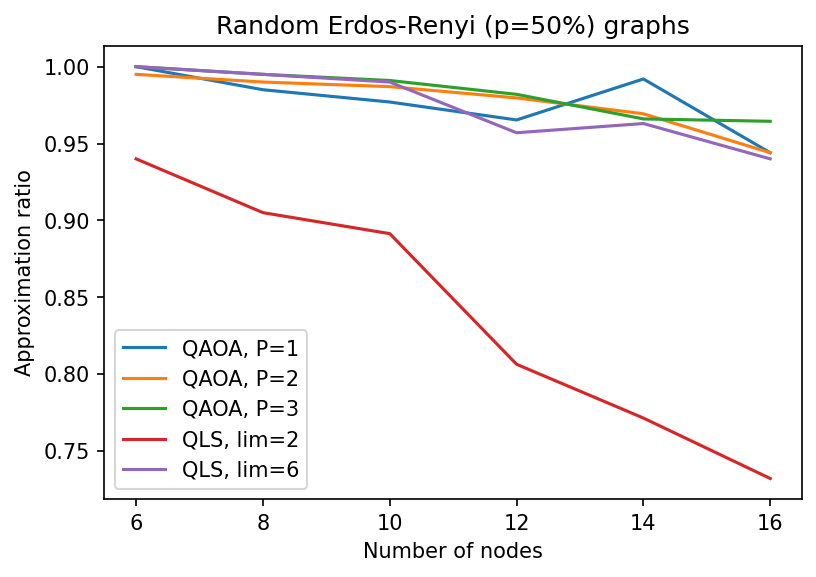

In [46]:
fig, ax = plt.subplots(dpi=150)

for sizes, approxs, label in data:
    ax.plot(sizes, approxs, label=label)
    
ax.set_ylabel('Approximation ratio')
ax.set_xlabel('Number of nodes')
ax.set_title('Random Erdos-Renyi (p=50%) graphs'.format(d))
ax.legend()
plt.show()
plt.close()

In [39]:
mis_list = lists[0][1]
medians = [np.median(l) for l in mis_list]
print(medians)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


[-0.2 -0.1  0.   0.1  0.2]
QAOA, P=1
QAOA, P=2
QAOA, P=3
QLS, lim=2
QLS, lim=6


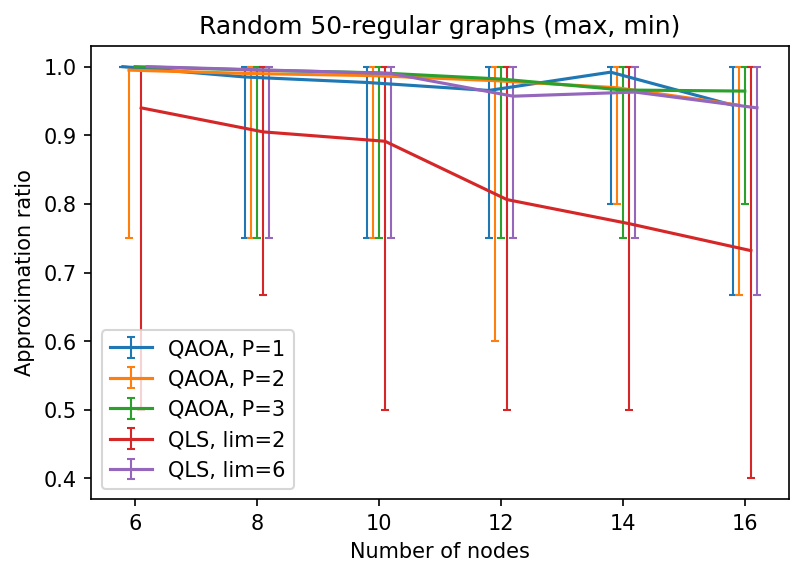

In [40]:
fig, ax = plt.subplots(dpi=150)

offset = np.linspace(-0.2, 0.2, len(lists))
print(offset)

for i, (sizes, mis_list, label) in enumerate(lists):
    print(label)
    sizes = np.array(sizes) + offset[i]
    vals = [np.mean(l) for l in mis_list]
    upper_err = [abs(np.max(l) - z) for l, z in zip(mis_list, vals)]
    lower_err = [abs(np.min(l) - z) for l, z in zip(mis_list, vals)]
    #print(vals)
    #print(upper_err)
    #print(lower_err)
    ax.errorbar(sizes, vals, yerr=[lower_err, upper_err], label=label, elinewidth=1, capsize=2)
    
ax.set_ylabel('Approximation ratio')
ax.set_xlabel('Number of nodes')
ax.set_title('Random {}-regular graphs (max, min)'.format(d))
ax.legend()
plt.show()
plt.close()

[-0.2 -0.1  0.   0.1  0.2]
QAOA, P=1
QAOA, P=2
QAOA, P=3
QLS, lim=2
QLS, lim=6


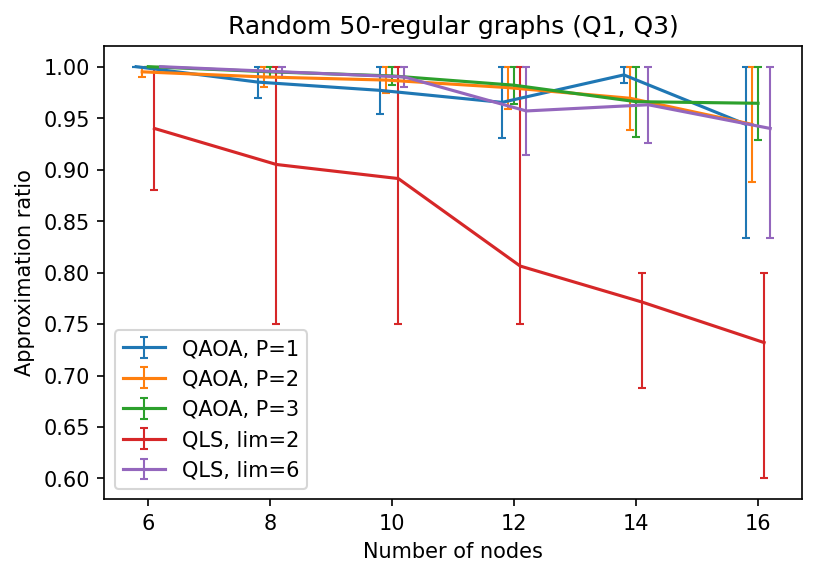

In [41]:
fig, ax = plt.subplots(dpi=150)

offset = np.linspace(-0.2, 0.2, len(lists))
print(offset)

for i, (sizes, mis_list, label) in enumerate(lists):
    print(label)
    sizes = np.array(sizes) + offset[i]
    vals = [np.mean(l) for l in mis_list]
    upper_err = [abs(np.quantile(l, 0.75) - z) for l, z in zip(mis_list, vals)]
    lower_err = [abs(np.quantile(l, 0.25) - z) for l, z in zip(mis_list, vals)]
    #print(vals)
    #print(upper_err)
    #print(lower_err)
    ax.errorbar(sizes, vals, yerr=[lower_err, upper_err], label=label, elinewidth=1, capsize=2)
    
ax.set_ylabel('Approximation ratio')
ax.set_xlabel('Number of nodes')
ax.set_title('Random {}-regular graphs (Q1, Q3)'.format(d))
ax.legend()
plt.show()
plt.close()

# Do DQVA and QLS improve in later rounds?

In [42]:
def get_pickles(alg, P, sim, n, d, lim=None):
    
    retval = []
    
    base_path = 'benchmark_results/{}_P{}_{}/'.format(alg, P, sim)
    if d < 10:
        graph_paths = 'N*_d{}_graphs/'.format(d)
    else:
        graph_paths = 'N*_p{}_graphs/'.format(d)
    
    graph_dirs = glob.glob(base_path + graph_paths)
    graph_dirs = sorted(graph_dirs, key=lambda fn: int(fn.split('/')[-2].split('_')[0].strip('N')))
    
    for gd in graph_dirs:
        #print(gd)
        all_graphs = glob.glob(gd+'*')
        temp_mis_approx = []
        for graph in all_graphs:
            #print('\t', graph)
            graphfn = 'benchmark_graphs/' + '/'.join(graph.split('/')[-2:]) + '.txt'
            G = graph_from_file(graphfn)
            
            temp_name = graph.split('/')[-2:]
            graph_name = temp_name[0].strip('graphs') + temp_name[1]
            
            opt = brute_force_search(G)[1]
            #print('\t Opt =', opt)
            if alg == 'qlsa' and d > 10:
                if lim is None:
                    raise Exception('Must specify lim parameter with alg=qlsa')
                reps = glob.glob(graph+'/*_lim{}_*'.format(lim))
            else:
                reps = glob.glob(graph+'/*')
            temp_pickles = []
            for pklfile in reps:
                #print('\t\t', pklfile)
                with open(pklfile, 'rb') as pf:
                    res = pickle.load(pf)
                    #print('\t'*3, res['graph'])
                    #print('\t'*3, res['out'][0])
                    temp_pickles.append(res['out'])
        
            # after collecting reps for this graph, store the results
            retval.append((G, opt, temp_pickles, graph_name))
            
    return retval

In [43]:
def plot_qls_approxs(data, savedir=None, show=True, verbose=0):
    
    G, opt, outs, graph_name = data
    print(graph_name)
    print('Opt =', opt)
    
    fig, ax = plt.subplots(dpi=150)

    for r, out in enumerate(outs):
        best_mis, best_params, best_init, best_mixer, history = out
        if verbose > 0:
            print('\nRep', r + 1)
            print(best_mis, best_init, best_mixer, len(history))
        num_mixer_rounds = len(history)
        x_vals, y_vals = [], []
        for i, mixer_round in enumerate(history):
            num_inner_rounds = len(mixer_round)

            for j, inner_round in enumerate(mixer_round):
                x_vals.append(i+1 + j/(num_inner_rounds+1))
                y_vals.append(abs(inner_round['cost'] / opt))
                if verbose > 0:
                    print('\t Mixer={}, Inner={}'.format(i+1, j+1))
                    print('\t', inner_round)

        ax.plot(x_vals, y_vals, c='b', alpha=0.2)
        ax.scatter(x_vals, y_vals, c='b', alpha=0.2, s=20)

    for i in range(1, num_mixer_rounds+1):
        ax.axvline(x=i, c='k', ls='--', alpha=0.3)

    ax.set_title('QLS MIS approximations for Graph {}'.format(graph_name))
    ax.set_ylabel('Approximation Ratio')
    ax.set_xlabel('Mixer & Inner Rounds')
    
    if not savedir is None:
        if savedir[-1] != '/':
            savedir += '/'
        plt.savefig(savedir + graph_name + '.png')
        
    if show:
        plt.show()
    plt.close()

In [44]:
qlsa_N6_p20_data = get_pickles('qlsa', 1, 'qasm', 6, 20, lim=2)
g1_data = qlsa_N6_p20_data[0]

N6_p20_G31
Opt = 4


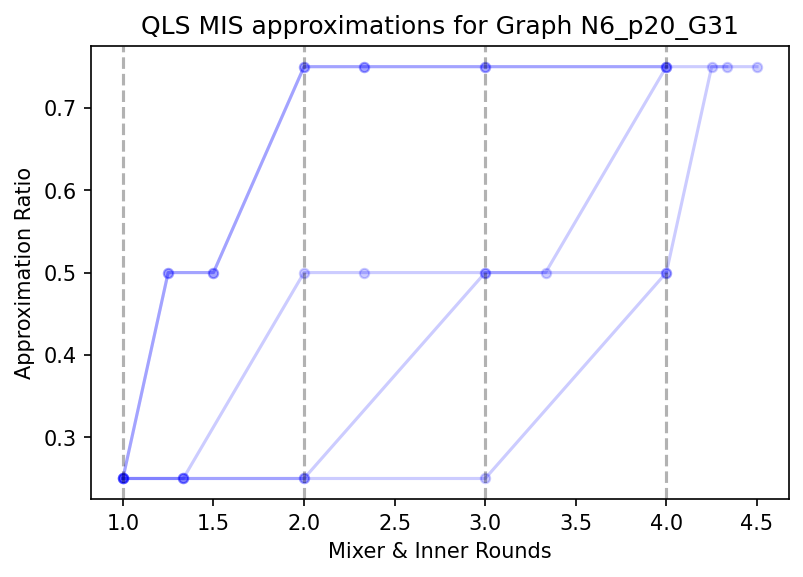

In [45]:
plot_qls_approxs(g1_data, verbose=0)

In [56]:
# Plot and save all of the qls results
for N in [6, 8, 10, 12, 14, 16]:
    for d in [20, 30, 50, 80]:
        for lim in [2, 4, 6]:
            qlsa_data = get_pickles('qlsa', 1, 'qasm', N, d, lim=lim)
            for data in qlsa_data:
                plot_qlsa_approxs(data, savedir='figures/qlsa_approximations/lim{}/'.format(lim), show=False)

N6_p20_G31
Opt = 4
N6_p20_G36
Opt = 3
N6_p20_G38
Opt = 4
N6_p20_G6
Opt = 3
N6_p20_G1
Opt = 3
N6_p20_G8
Opt = 3
N6_p20_G39
Opt = 3
N6_p20_G37
Opt = 3
N6_p20_G30
Opt = 3
N6_p20_G9
Opt = 3
N6_p20_G7
Opt = 3
N6_p20_G48
Opt = 3
N6_p20_G41
Opt = 3
N6_p20_G46
Opt = 3
N6_p20_G12
Opt = 3
N6_p20_G15
Opt = 3
N6_p20_G23
Opt = 3
N6_p20_G24
Opt = 3
N6_p20_G47
Opt = 3
N6_p20_G40
Opt = 3
N6_p20_G49
Opt = 4
N6_p20_G25
Opt = 3
N6_p20_G22
Opt = 3
N6_p20_G14
Opt = 3
N6_p20_G13
Opt = 4
N6_p20_G2
Opt = 3
N6_p20_G50
Opt = 3
N6_p20_G5
Opt = 3
N6_p20_G35
Opt = 4
N6_p20_G32
Opt = 3
N6_p20_G4
Opt = 4
N6_p20_G3
Opt = 3
N6_p20_G33
Opt = 4
N6_p20_G34
Opt = 3
N6_p20_G16
Opt = 4
N6_p20_G29
Opt = 3
N6_p20_G11
Opt = 3
N6_p20_G27
Opt = 3
N6_p20_G18
Opt = 4
N6_p20_G20
Opt = 3
N6_p20_G45
Opt = 3
N6_p20_G42
Opt = 3
N6_p20_G21
Opt = 4
N6_p20_G26
Opt = 4
N6_p20_G19
Opt = 4
N6_p20_G10
Opt = 3
N6_p20_G17
Opt = 3
N6_p20_G28
Opt = 3
N6_p20_G43
Opt = 3
N6_p20_G44
Opt = 4
N8_p20_G31
Opt = 4
N8_p20_G36
Opt = 4
N8_p20_G38
Opt = 4
N8

KeyboardInterrupt: 

<Figure size 900x600 with 0 Axes>